### Подготовка данных к анализу

В данном исследовании мы возьмем на себя роль маркетингового аналитика развлекательного приложения Procrastinate Pro+. Несмотря на значительные вложения в рекламу, последние несколько месяцев компания терпит убытки. Наша задача — разобраться в причинах и помочь компании выйти в плюс.

Для этого у нас есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года, включающие:

- Лог сервера с данными об их посещениях.
- Выгрузка их покупок за этот период.
- Рекламные расходы.

Нам предстоит изучить:

- Источники пользователей и используемые устройства - определить, откуда приходят пользователи и какими устройствами они пользуются.
- Стоимость привлечения пользователей - проанализировать, сколько стоит привлечение пользователей из различных рекламных каналов.
- Доходы от клиентов - рассчитать, сколько денег приносит каждый клиент.
- Окупаемость расходов на привлечение клиентов - определить, когда расходы на привлечение клиента окупаются.
- Факторы, мешающие привлечению клиентов - выявить и проанализировать факторы, которые могут мешать успешному привлечению клиентов.

Для анализа у вас есть три датасета:

- Файл visits_info_short.csv: хранит лог сервера с информацией о посещениях сайта.
- Файл orders_info_short.csv: содержит информацию о заказах.
- Файл costs_info_short.csv: предоставляет данные о расходах на рекламу.

Структура visits_info_short.csv:

- User Id: уникальный идентификатор пользователя.
- Region: страна пользователя.
- Device: тип устройства пользователя.
- Channel: идентификатор источника перехода.
- Session Start: дата и время начала сессии.
- Session End: дата и время окончания сессии.

Структура orders_info_short.csv:

- User Id: уникальный идентификатор пользователя.
- Event Dt: дата и время покупки.
- Revenue: сумма заказа.

Структура costs_info_short.csv:

- dt: дата проведения рекламной кампании.
- Channel: идентификатор рекламного источника.
- costs: расходы на эту кампанию.

Для начала загрузим все нужные для работы библиотеки.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

Напшим функцию для проведения первичного анализа датафреймов.

In [2]:
def primary_analysis(df):

    print("Информация о датафрейме:")
    print(df.info())
    
    print("\nПервые 5 строк датафрейма:")
    print(df.head())
    
    print("\nОписание численных столбцов:")
    print(df.describe())
    
    print("\nКоличество явных дубликатов в датасете:")
    print(df.duplicated().sum())
    
    print("\nЧастота распределений для категориальных столбцов:")
    for column in df.select_dtypes(include=['object', 'category']).columns:
        print(f"\nСтолбец '{column}':")
        print(df[column].value_counts())

Загрузим данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные:

In [3]:
visits, orders, ad_costs = (
    pd.read_csv('/datasets/visits_info_short.csv'),  # журнал сессий
    pd.read_csv('/datasets/orders_info_short.csv'),  # заказы
    pd.read_csv('/datasets/costs_info_short.csv'),  # расходы
)
events = None

Изучим данные с помощью функций head() и info().

In [4]:
primary_analysis(visits)

Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
None

Первые 5 строк датафрейма:
        User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:

Вызывают сомнения два последних столбца, "Session Start" и "Session End", которые содержат дату и время, но формат ячеек обозначен как object. Пропуски отсутствуют. Явные и неявные дубликаты тоже. Также лучше изменить регистр у названий столбцов. Сейчас обратим внимание на другие наборы данных.

In [5]:
primary_analysis(orders)

Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
None

Первые 5 строк датафрейма:
        User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

Описание численных столбцов:
            User Id       Revenue
count  4.021200e+04  40212.000000
mean   4.990295e+11      5.370608
std    2.860937e+11      3.454208
min    5.993260e+05      4.990000
25%    2.511324e+11      4.990000
50%    4.982840e+11      4.990000
75%    7.433327e+11      4.9900

Также наблюдаем, что в Event Dt указан неправильный формат. Пропусков и дубликатов нет. Идем дальше.

In [6]:
primary_analysis(ad_costs)

Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
None

Первые 5 строк датафрейма:
           dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

Описание численных столбцов:
             costs
count  1800.000000
mean     58.609611
std     107.740223
min       0.800000
25%       6.495000
50%      12.285000
75%      33.600000
max     630.000000

Количество явных дубликатов в датасете:
0

Частота распределений для категориальных столбцов:

Столбец 'dt':
2019-06-09    10
2019-07-23    10
2019-10-26    10
2019-06-04    10
2019-06-11    10
           

Приведем названия столбцов к правильному формату и поменяем формат столбцов, где содеражатя даты и время

In [7]:
visits.columns = [x.lower().replace(' ', '_') for x in visits.columns]
orders.columns = [x.lower().replace(' ', '_') for x in orders.columns]
ad_costs.columns = [x.lower().replace(' ', '_') for x in ad_costs.columns]

In [8]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
ad_costs['dt'] = pd.to_datetime(ad_costs['dt']).dt.date 

In [9]:
visits.info()
orders.info()
ad_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.

Предобработка данных завершена. В ходе проверки не было выявлено явных и неявных дубликатов, а также пропусков. Типы данных всех столбцов приведены в соответствие с их содержимым. На данном этапе данные полностью подготовлены для дальнейшего анализа. Можем переходить к следующему этапу работы.

### Функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Соберём функции для создания профилей, расчёта удержания, конверсии, LTV и ROI, а также функции для визуализации этих метрик.

Метрики:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

Графики:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [10]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].values.astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [11]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [12]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [13]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [14]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [15]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [16]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [17]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

Все функции подготовлены для использования. Можем двигаться к исследовательскому анализу данных.

### Исследовательский анализ данных

Приступим к исследовательскому анализу данных. Для начала составим профили пользователей. Для этого вызовем функцию get_profiles(), передав ей данные о посещениях, покупках и тратах на рекламу. 

In [18]:
profiles = get_profiles(visits, orders, events, ad_costs)
display(profiles.head())

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Определим минимальную и максимальную даты привлечения пользователей или доступный интервал привлечения пользователей.


In [19]:
min_analysis_date = profiles['dt'].min()
min_analysis_date

datetime.date(2019, 5, 1)

In [20]:
observation_date =  profiles['dt'].max()# ваш код здесь
observation_date

datetime.date(2019, 10, 27)

Интервал привлечения пользователей соответствует заявленному периоду времени - с 1 мая по 27 октября 2019 года.

Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Для этого построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

Для начала напишим функцию для агрегации, которую используем для стран, а потом девайсов и каналов.

In [21]:
def aggregate_and_format_generic(df, group_by, agg_funcs):

    agg_df = df.groupby(group_by).agg(agg_funcs).reset_index()
    
    agg_df['total_users'] = agg_df['user_id']
    agg_df['paying_share'] = (agg_df['payer'] / agg_df['total_users']) * 100
    
    agg_df = agg_df.sort_values(by='paying_share', ascending=False)
    
    return agg_df.style.format({
        'non_payers': '{:,.0f}',
        'payers': '{:,.0f}',
        'total_users': '{:,.0f}',
        'paying_share': '{:.2f}%'
    })

In [22]:
region_payers = aggregate_and_format_generic(
    profiles,
    group_by='region',
    agg_funcs={
        'payer': 'sum',
        'user_id': 'nunique'
    }
)
region_payers

,region,payer,user_id,total_users,paying_share
3,United States,6902,100002,"100,002",6.90%
1,Germany,616,14981,"14,981",4.11%
2,UK,700,17575,"17,575",3.98%
0,France,663,17450,"17,450",3.80%


Можно сделать следующие выводы: 
- Самая высокая доля платящих пользователей наблюдается в Соединенных Штатах (6.90%), что значительно выше, чем в других регионах.
- Самая низкая доля платящих пользователей отмечается во Франции (3.80%), несмотря на сравнительно большое общее количество пользователей.
- Германия и Великобритания имеют схожие доли платящих пользователей, около 4.11% и 3.98% соответственно.

Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [23]:
region_payers = aggregate_and_format_generic(
    profiles,
    group_by='device',
    agg_funcs={
        'payer': 'sum',
        'user_id': 'nunique'
    }
)
region_payers

,device,payer,user_id,total_users,paying_share
1,Mac,1912,30042,"30,042",6.36%
3,iPhone,3382,54479,"54,479",6.21%
0,Android,2050,35032,"35,032",5.85%
2,PC,1537,30455,"30,455",5.05%


Можно сделать следующие выводы: 
- Самая высокая доля платящих пользователей наблюдается среди пользователей Mac (6.36%), что немного выше, чем у пользователей iPhone (6.21%).
- Самая низкая доля платящих пользователей отмечается у пользователей PC (5.05%), несмотря на сравнительно большое общее количество пользователей.
- Android устройства имеют долю платящих пользователей в 5.85%, что выше, чем у PC, но ниже, чем у устройств Apple (Mac и iPhone).

Изучим рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [24]:
region_payers = aggregate_and_format_generic(
    profiles,
    group_by='channel',
    agg_funcs={
        'payer': 'sum',
        'user_id': 'nunique'
    }
)
region_payers

,channel,payer,user_id,total_users,paying_share
1,FaceBoom,3557,29144,"29,144",12.20%
0,AdNonSense,440,3880,"3,880",11.34%
9,lambdaMediaAds,225,2149,"2,149",10.47%
6,TipTop,1878,19561,"19,561",9.60%
5,RocketSuperAds,352,4448,"4,448",7.91%
7,WahooNetBanner,453,8553,"8,553",5.30%
8,YRabbit,165,4312,"4,312",3.83%
3,MediaTornado,156,4364,"4,364",3.57%
2,LeapBob,262,8553,"8,553",3.06%
4,OppleCreativeMedia,233,8605,"8,605",2.71%


Можно сделать следующие выводы:
- FaceBoom демонстрирует самую высокую долю платящих пользователей (12.20%), что указывает на высокую эффективность этого канала.
- AdNonSense и lambdaMediaAds также имеют высокие доли платящих пользователей, 11.34% и 10.47% соответственно.
- organic канал показывает самую низкую долю платящих пользователей (2.06%), несмотря на самое большое общее количество пользователей (56,439).
- Каналы OppleCreativeMedia и LeapBob также имеют низкие доли платящих пользователей, 2.71% и 3.06% соответственно.

Анализ показывает, что эффективность кампании значительно варьируется в зависимости от региона, устройства и рекламного канала. Наиболее высокие показатели доли платящих пользователей наблюдаются в Соединенных Штатах, среди пользователей устройств Apple и пользователей, привлеченных через канал FaceBoom.

### Маркетинг

Посчитаем общую сумму расходов на маркетинг.

In [25]:
total = ad_costs['costs'].sum()
total

105497.30000000002

Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.

In [26]:
ad_costs_channel = (
    ad_costs.groupby('channel')
    .agg({'costs': 'sum'})
)
ad_costs_channel['costs_share'] = (ad_costs_channel['costs']/total)*100
ad_costs_channel.sort_values(by='costs_share',ascending=False)

,costs,costs_share
channel,,
TipTop,54751.30,51.898295
FaceBoom,32445.60,30.754910
WahooNetBanner,5151.00,4.882589
AdNonSense,3911.25,3.707441
OppleCreativeMedia,2151.25,2.039152
RocketSuperAds,1833.00,1.737485
LeapBob,1797.60,1.703930
lambdaMediaAds,1557.60,1.476436
MediaTornado,954.48,0.904744


Можно сделать следующие выводы: 
- Основная часть рекламного бюджета (более 80%) сосредоточена на двух каналах: TipTop и FaceBoom.
- Остальные каналы занимают значительно меньшую долю бюджета, каждый менее чем 5%.

Построим график с визуализацией динамики изменения расходов во времени по неделям по каждому источнику. Затем на другом графике визуализируйте динамику изменения расходов во времени по месяцам по каждому источнику.

In [27]:
ad_costs['dt'] = pd.to_datetime(ad_costs['dt'])
ad_costs['week'] = ad_costs['dt'].dt.isocalendar().week
ad_costs['month'] = ad_costs['dt'].dt.month
ad_costs

,dt,channel,costs,week,month
0,2019-05-01,FaceBoom,113.3,18,5
1,2019-05-02,FaceBoom,78.1,18,5
2,2019-05-03,FaceBoom,85.8,18,5
3,2019-05-04,FaceBoom,136.4,18,5
4,2019-05-05,FaceBoom,122.1,18,5
...,...,...,...,...,...
1795,2019-10-23,lambdaMediaAds,4.0,43,10
1796,2019-10-24,lambdaMediaAds,6.4,43,10
1797,2019-10-25,lambdaMediaAds,8.8,43,10
1798,2019-10-26,lambdaMediaAds,8.8,43,10


In [28]:
ad_costs_weekly = (
    ad_costs.groupby(['week', 'channel'])
    .agg({'costs': 'sum'})
    .reset_index()
)
ad_costs_weekly

,week,channel,costs
0,18,AdNonSense,211.05
1,18,FaceBoom,535.70
2,18,LeapBob,16.80
3,18,MediaTornado,38.64
4,18,OppleCreativeMedia,24.00
...,...,...,...
255,43,RocketSuperAds,50.70
256,43,TipTop,3265.50
257,43,WahooNetBanner,253.20
258,43,YRabbit,48.33


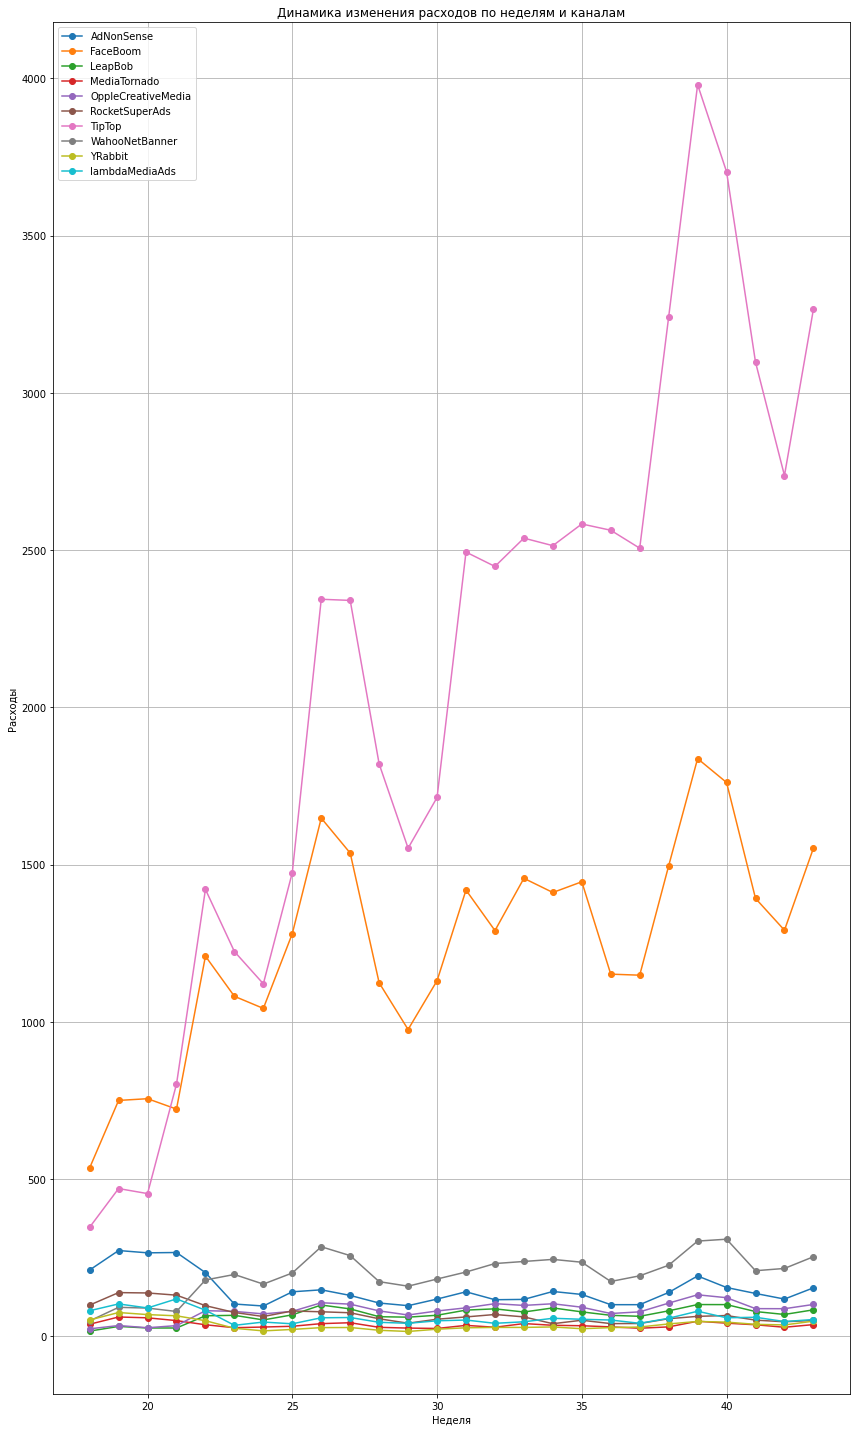

In [29]:
plt.figure(figsize=(12, 20))
for channel in ad_costs_weekly['channel'].unique():
    channel_data = ad_costs_weekly[ad_costs_weekly['channel'] == channel]
    plt.plot(channel_data['week'], channel_data['costs'], marker='o', linestyle='-', label=channel)
plt.xlabel('Неделя')
plt.ylabel('Расходы')
plt.title('Динамика изменения расходов по неделям и каналам')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

На графике мы можем увидеть подтверждение наших гипотез о том, что основная часть бюджета направлена на два канала: TipTop и FaceBoom. Наблюдается постоянный рост расходов на эти каналы, за исключением снижения между 27 и 30 неделями. С 32 по 37 неделю расходы остаются стабильными, после чего происходит резкий скачок в 37-39 недели для обоих каналов. Для остальных же каналов расходы остаются стабильно небольшими.

In [30]:
ad_costs_monthly = (
    ad_costs.groupby(['month', 'channel'])
    .agg({'costs': 'sum'})
    .reset_index()
)
ad_costs_monthly

,month,channel,costs
0,5,AdNonSense,1169.700
1,5,FaceBoom,3524.400
2,5,LeapBob,140.280
3,5,MediaTornado,238.560
4,5,OppleCreativeMedia,169.750
5,5,RocketSuperAds,577.980
6,5,TipTop,2981.000
7,5,WahooNetBanner,418.800
8,5,YRabbit,299.700
9,5,lambdaMediaAds,458.400


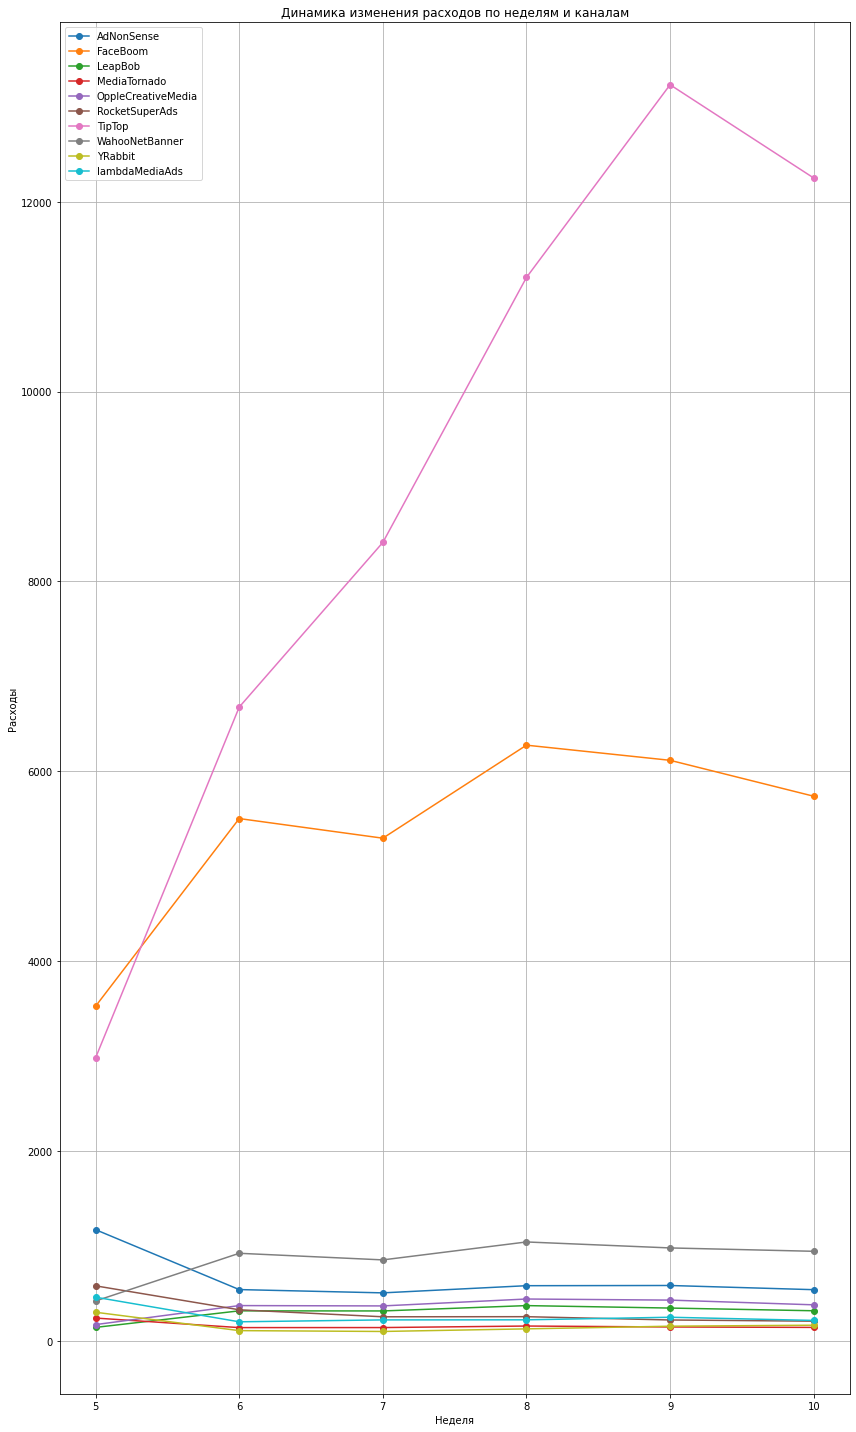

In [31]:
plt.figure(figsize=(12, 20))
for channel in ad_costs_monthly['channel'].unique():
    channel_data = ad_costs_monthly[ad_costs_monthly['channel'] == channel]
    plt.plot(channel_data['month'], channel_data['costs'], marker='o', linestyle='-', label=channel)
plt.xlabel('Неделя')
plt.ylabel('Расходы')
plt.title('Динамика изменения расходов по неделям и каналам')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

FaceBoom и TipTop являются наиболее крупными и постоянно используемыми каналами для размещения рекламы. Они имеют самые высокие расходы в большинстве месяцев. Каналы, такие как AdNonSense и MediaTornado, демонстрируют более стабильные расходы в течение различных месяцев.

Дальше узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Для этого используем профили пользователей и построим графики.

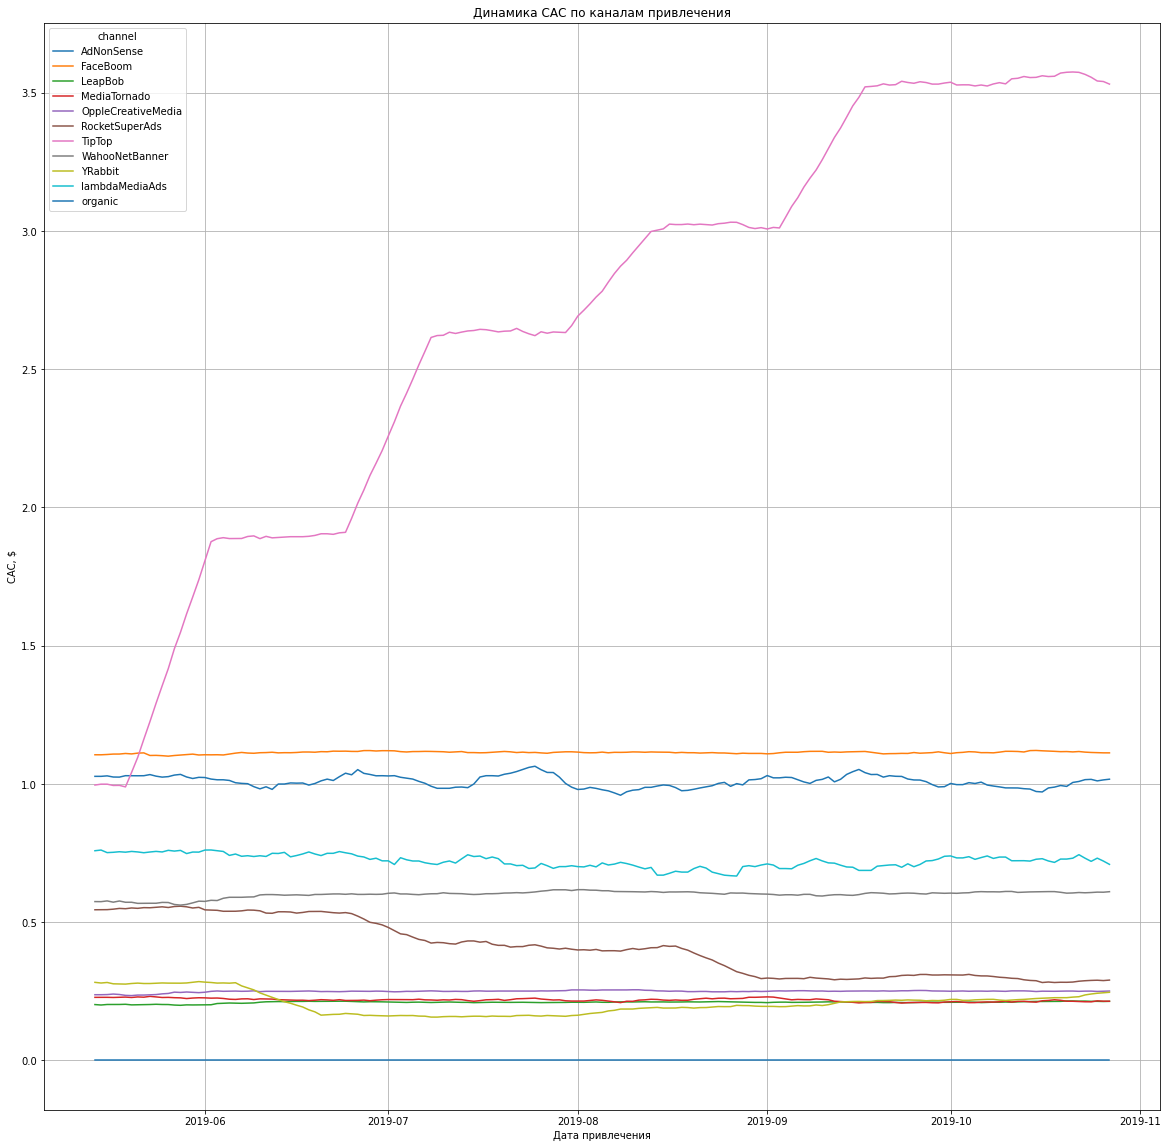

In [32]:
report = profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
)
window = 14
filter_data(report, window).plot(grid=True, figsize=(20, 20))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

При первом взгляде на данный график бросается в глаза значительное изменение стоимости привлечения одного пользователя для канала TipTop в разные временные периоды: с 1 до 2 в июне, с 2 до 2.6 в июле, от 2.6 до 3 в августе, и от 3 до 3.5 в сентябре. В то время как для каналов FaceBoom и AdNonSense наблюдаются более стабильные показатели около 1 за пользователя. Все остальные каналы разместились в диапазоне от 0 до 1, с наиболее крупным скоплением в районе 25 центов за клиента, причем эту позицию занимают четыре канала продвижения.

Из анализа данных следует, что основная часть рекламного бюджета компании (более 80%) направлена на два ключевых канала: TipTop и FaceBoom. Эти каналы демонстрируют постоянный рост расходов, с некоторыми колебаниями в разные периоды времени.

FaceBoom и TipTop выделяются среди прочих каналов как наиболее крупные и стабильные в использовании для размещения рекламы. Стоимость привлечения одного пользователя в TipTop значительно колеблется в зависимости от времени: от 1 до 3.5 за клиента в различные месяцы. В то же время, стоимость привлечения пользователя через FaceBoom и AdNonSense остается более стабильной, в пределах примерно 1 за клиента.

Остальные каналы распределены среди более низких бюджетов, преимущественно в диапазоне от 0 до 1 за пользователя, с наибольшим скоплением каналов в области около 25 центов за клиента.

### Оцените окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируем окупаемость рекламы и попробуем найти аномалии в них.

Для начала установим момент и горизонт анализа. Считаем, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Исключаем органический трафик.

In [33]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа

In [34]:
filtered_profiles = profiles.query('channel != "organic"')

Для начала оценим общую ситуацию — посмотрим на окупаемость рекламы. Рассчитаем и визуализируем LTV и ROI, вызвав функции get_ltv() и plot_ltv_roi().

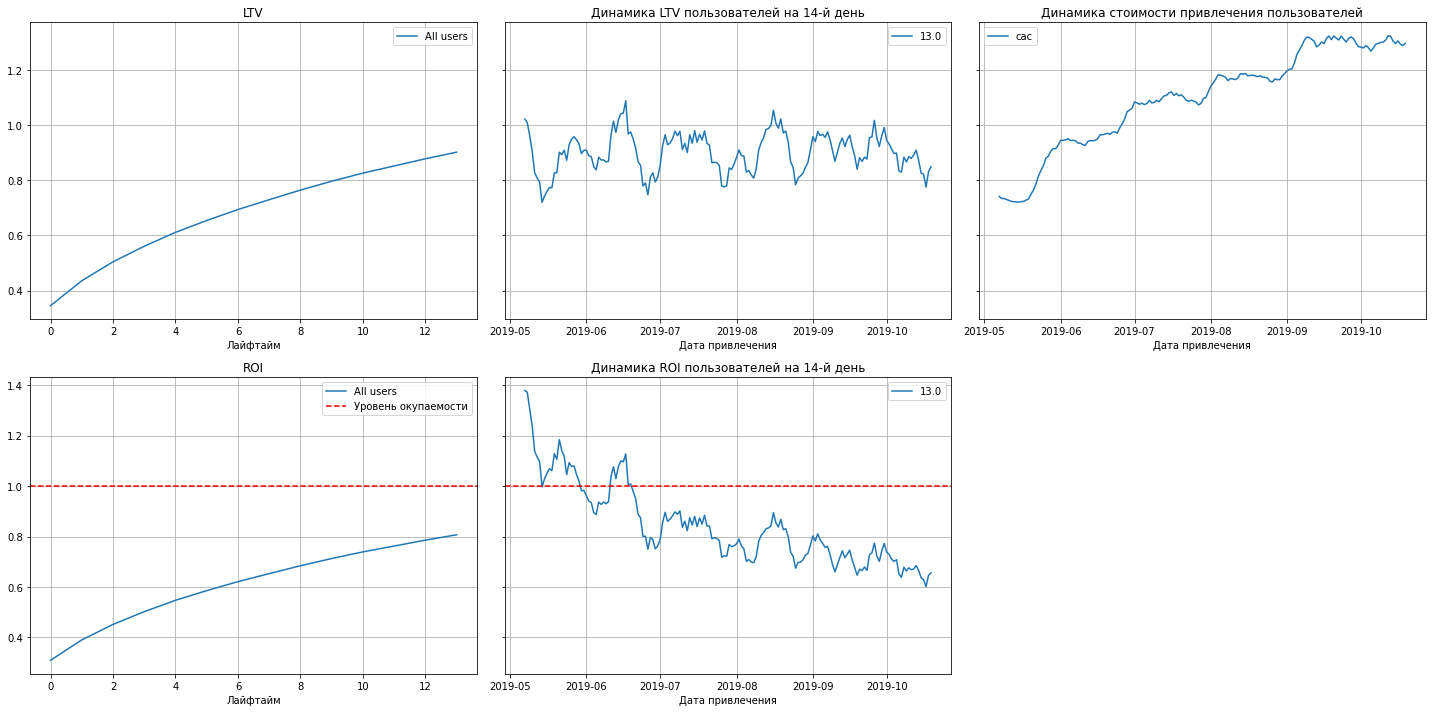

In [35]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    filtered_profiles, orders, observation_date, horizon_days
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

По графикам можно сделать следующие выводы:

- Видно, что LTV растет со временем, что означает, что клиенты приносят все больше дохода по мере продолжения взаимодействия c приложением. В динамике LTV не стабилен, но в целом тренд показывает устойчивый рост с некоторыми периодами снижения.
- CAC не стабилен - мы можем заметить постоянный рост, что может указывать на постоянное повышение затрат на маркетинг. Скачок во второй половине мая и равномерный рост, начиная с начала июня. 
- ROI растет со временем, что означает, что возврат на инвестиции увеличивается по мере продолжения взаимодействия с клиентами. Однако он не достигает единицы, что говорит, о том что маркетинговые затраты не окупились. Можно также заметить, что ROI в начале рассматриваемого периода (до конца мая) превышает уровень окупаемости, но затем, начиная с начала июня, снижается и опускается ниже уровня окупаемости, что может быть причиной для беспокойства.

Главное, на что стоит обратить внимание:
- Cтоимость привлечения одного пользователя значительно растет - скачком с середины мая по конец мая и равномерно с начала июня по конец периода с локальными незначительными снижениями
- Окупаемость не достигнута

Посчитаем и визуализируем общую конверсию, вызвав функции get_conversion() и plot_conversion().

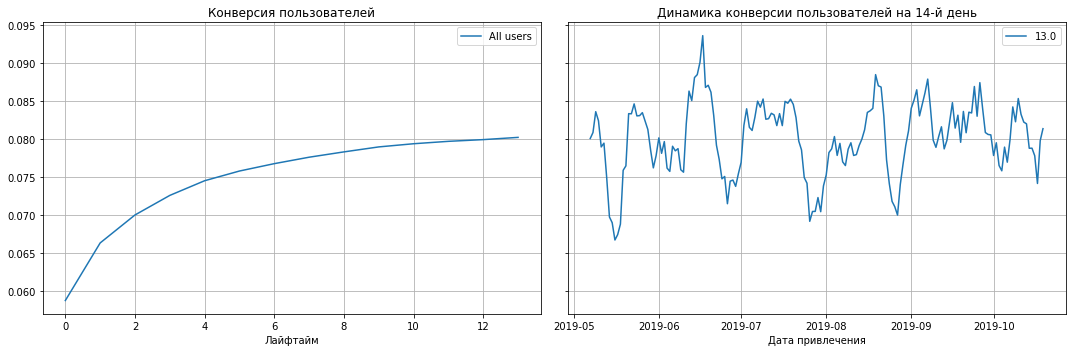

In [36]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    filtered_profiles, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Видно, что конверсия пользователей растет с течением времени, достигая уровня около 8%. Это означает, что все больше пользователей совершают покупку по мере продолжения их взаимодействия с продуктом. В динамике, несмотря на сильные колебания, уровень конверсии держится в диапазоне между 6.5% и 9.5%.

Посчитаем и визуализируем конверсию по регионам, вызвав функции get_conversion() и plot_conversion().

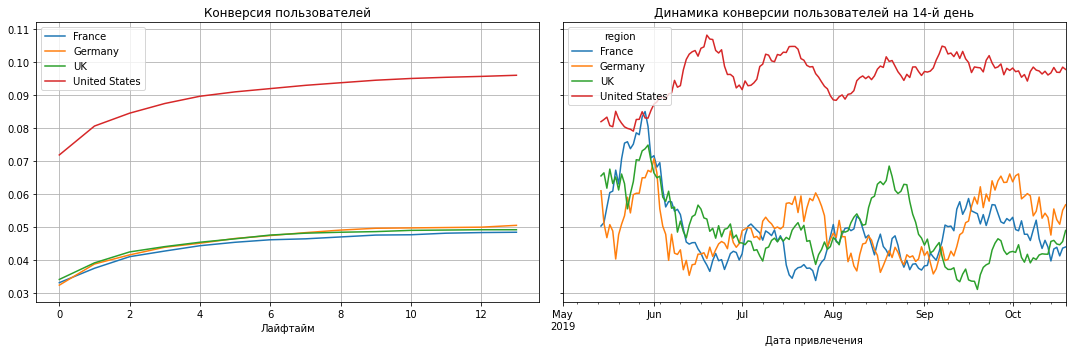

In [37]:
dimensions = ['region']
window = 14

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    filtered_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days,window)

Видно, что конверсия пользователей растет для всех регионов. Однако монжно заметить, что конверсия пользователей из США гораздо выше и достигает 10 процентов. Все остальные регионы располагаются в одной области с 3% до 5%. 

Посчитаем и визуализируем конверсию по девайсам, вызвав функции get_conversion() и plot_conversion().

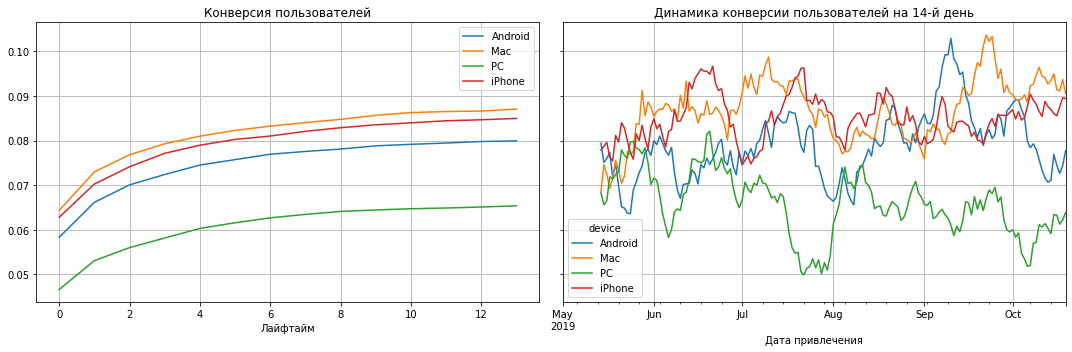

In [38]:
dimensions = ['device']
window = 14

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    filtered_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days,window)

Видно, что конверсия пользователей растет для всех девайсов. Однако монжно заметить, что конверсия пользователей Mac и iPhone гораздо выше и достигает 9 процентов. Недавлеко расположлись пользователи с Android c 8%. Самая низкая конверсия у пользователей PC.

Посчитаем и визуализируем конверсию по каналам, вызвав функции get_conversion() и plot_conversion().

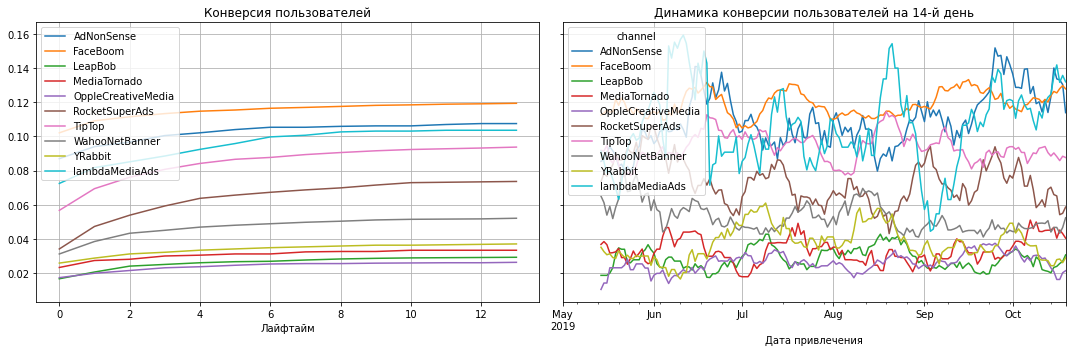

In [39]:
dimensions = ['channel']
window = 14

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    filtered_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days,window)

Судя по графикам, можно констатировать следующее: 
- AdNonSense и FaceBoon демонстрируют наиболее высокую конверсию, достигая примерно 0.12-0.15 к концу наблюдаемого периода.
- LeapBob и RocketSuperAds также показывают хорошие результаты, хотя их конверсия немного ниже, около 0.10-0.12.
- MediaTornado и TipTop находятся на среднем уровне, достигая конверсии около 0.08-0.10.
- OppleCreativeMedia, WahooNetBanner, YRabbit и IambdaMediaAds имеют более низкие показатели, в районе 0.02-0.06.

Посчитаем и визуализируем общее удержание, вызвав функции get_retention() и plot_retention().

In [40]:
filtered_visits = visits.query('channel != "organic"')

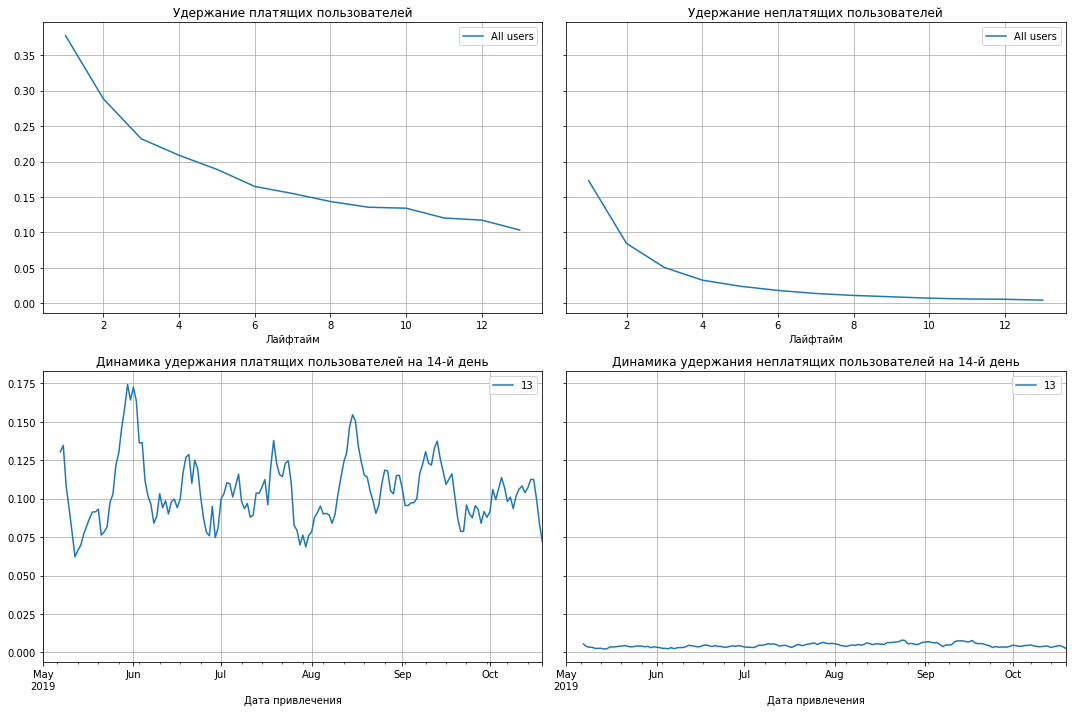

In [41]:
retention_raw, retention_grouped, retention_history = get_retention(
    filtered_profiles, filtered_visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days) 

По графикам можно сделать следующие выводы:

- Видно, что удержание платящих пользователей снижается с течением времени, начиная с уровня около 0.35 и достигая уровня ниже 0.10 к 12-му дню, что говорит о значительном снижении, что указывает на необходимость анализа причин и поиска стратегий для улучшения удержания этой категории пользователей.
- Удержание неплатящих пользователей также снижается с течением времени, начиная с уровня около 0.07 и достигая практически нулевого уровня к 12-му дню, что может свидетельствовать о слабом интересе или неудовлетворенности неплатящих пользователей.

Посчитаем и визуализируем удержание по регионам, вызвав функции get_retention() и plot_retention().

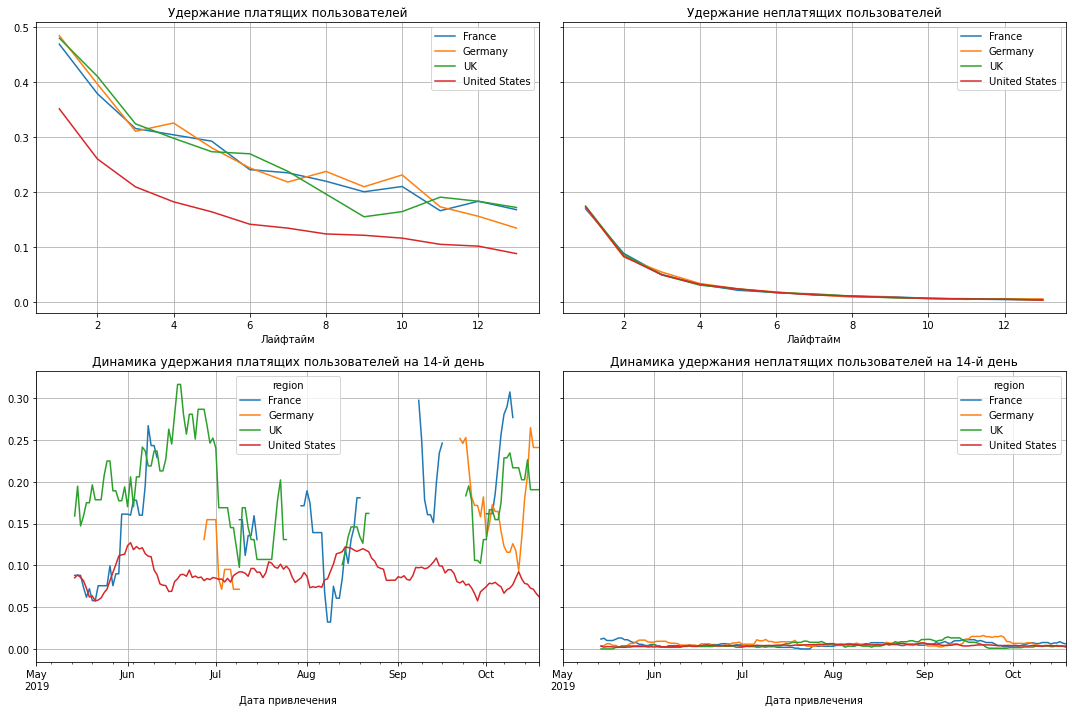

In [42]:
dimensions = ['region']
window = 14

retention_raw, retention_grouped, retention_history = get_retention(
    filtered_profiles, filtered_visits, observation_date, horizon_days, dimensions=dimensions 
)

plot_retention(retention_grouped, retention_history, horizon_days, window) 

По графикам можно сделать следующие выводы:

- Видно, что удержание платящих пользователей снижается с течением времени для всех регионов. Франция, Германия и Великобритания показывают схожие тенденции, с более высоким удержанием, чем в США. Удержание в США падает значительно быстрее.
- Для неплатящих пользователей виден резкий спад удержания в течение первых нескольких дней, а затем стабилизация на низком уровне. Различия между странами минимальны - неплатящие пользователи почти не удерживаются во всех странах.

Посчитаем и визуализируем удержание по девайсам, вызвав функции get_retention() и plot_retention().

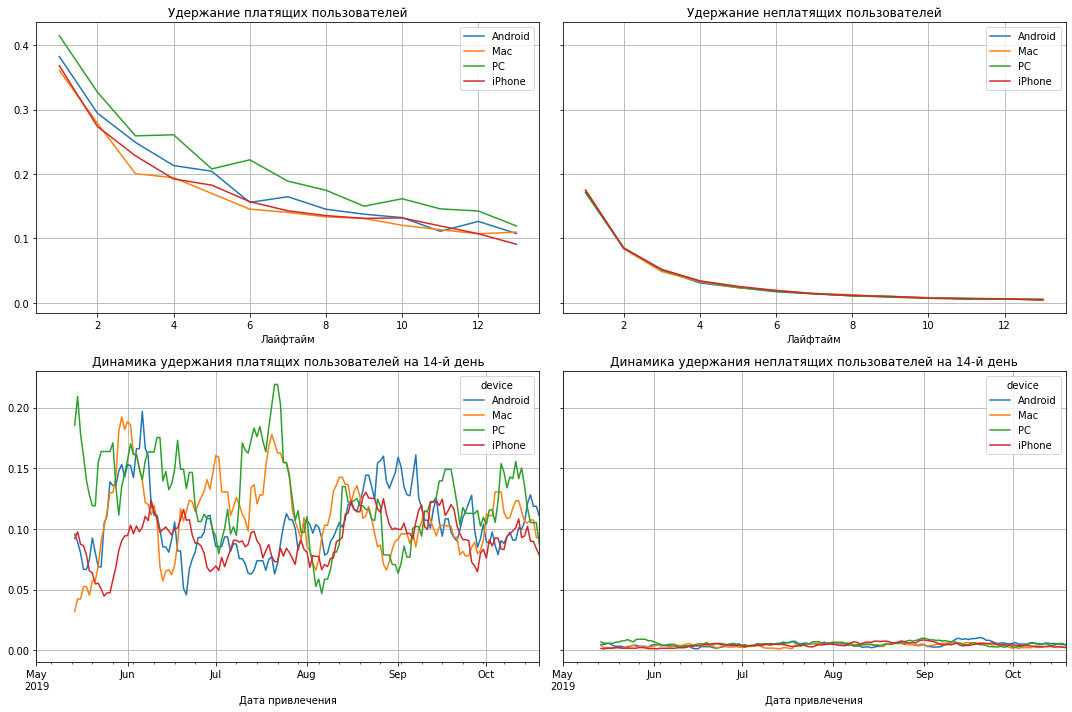

In [43]:
dimensions = ['device']
window = 14

retention_raw, retention_grouped, retention_history = get_retention(
    filtered_profiles, filtered_visits, observation_date, horizon_days, dimensions=dimensions 
)

plot_retention(retention_grouped, retention_history, horizon_days, window) 

- Видно, что удержание платящих пользователей снижается по мере увеличения времени для всех устройств. На устройствах Android и PC удержание выше по сравнению с Mac и iPhone, где оно снижается более быстро.
- Для неплатящих пользователей видно, что все устройства демонстрируют очень схожие тенденции: резкий спад удержания в течение первых нескольких дней, после чего наступает стабилизация на низком уровне.

Посчитаем и визуализируем удержание по каналам, вызвав функции get_retention() и plot_retention().

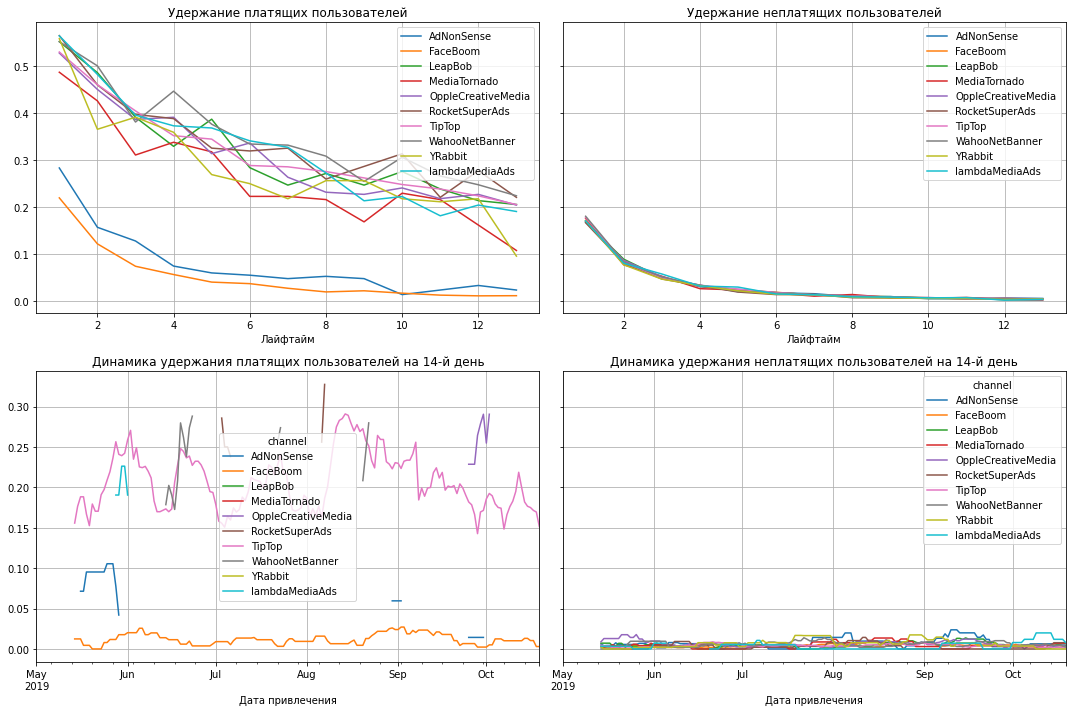

In [44]:
dimensions = ['channel']
window = 14

retention_raw, retention_grouped, retention_history = get_retention(
    filtered_profiles, filtered_visits, observation_date, horizon_days, dimensions=dimensions 
)

plot_retention(retention_grouped, retention_history, horizon_days, window) 

- Каналы AdNonSense, FaceBoom, LeapBob и MediaTornado демонстрируют более низкое удержание по сравнению с другими каналами. В то же время каналы TipTop и OppleCreativeMedia показывают более высокие уровни удержания.
- Также как и для других факторов - все каналы показывают очень схожие тенденции: резкий спад удержания в течение первых нескольких дней, после чего наступает стабилизация на низком уровне.

Проанализируем окупаемость рекламы с разбивкой по устройствам

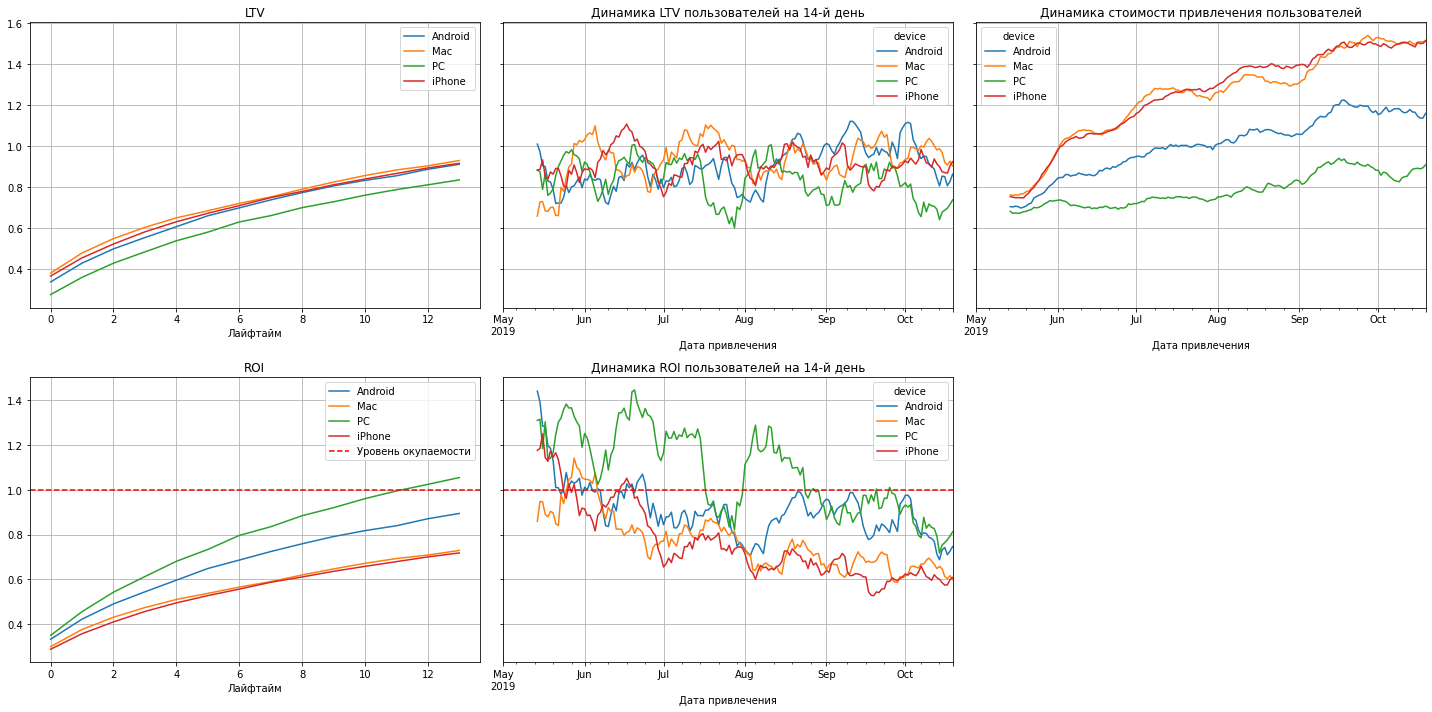

In [45]:
dimensions = ['device']
window = 14

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    filtered_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window
) 

По графикам можно сделать следующие выводы:

- Видно, что LTV растет со временем. Можно выделить LTV для пользователей PC, которое чуть ниже остальных девайсов. Остальные девайсы находятся примерно в одной области графика. В динамике LTV также не стабилен для различных девайсов, но в целом тренд показывает устойчивый рост с некоторыми периодами снижения.
- CAC не стабилен – можно заметить постоянный рост затрат на маркетинг для всех видов девайсов, особенно для Mac и iPhone. Меньше всего CAC для пользователей PC.
- Для пользователей Mac, iPhone, Android ROI не достигает единицы, в отличие от других платформ. Это означает, что затраты на привлечение пользователей для этих устройств не окупаются. Возможно, стоит обратить пристальное внимание на эти платформы, чтобы найти способы улучшить их показатели ROI.

Главное, на что стоит обратить внимание:
- Cтоимость привлечения одного пользователя значительно растет для всех устройств, но в особенности для Mac и iPhone и копирует тренд из общего анализа. 
- Окупаемость для Mac, iPhone, Android не достигнута

Проанализируем окупаемость рекламы с разбивкой по странам.

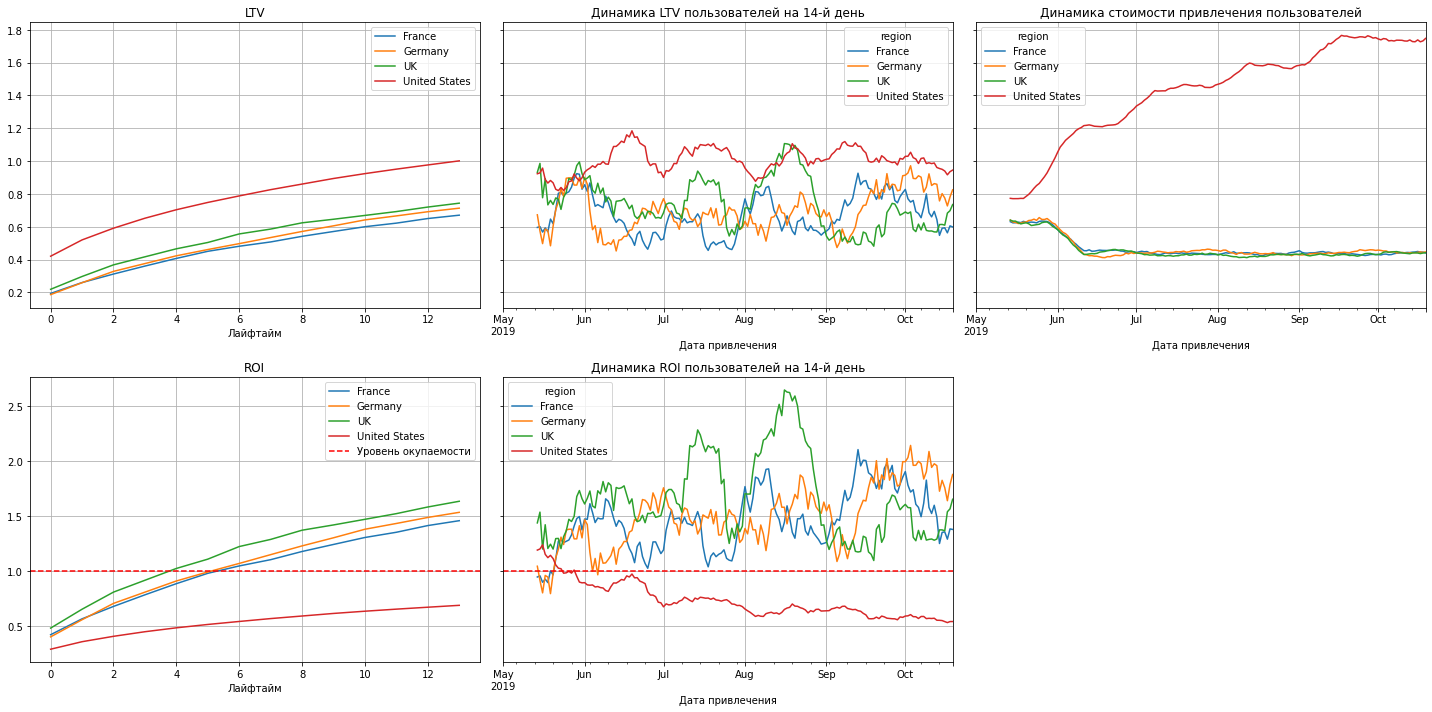

In [46]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    filtered_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

По графикам можно сделать следующие выводы:

- В США показатель LTV значительно выше и растет быстрее, чем в других странах. Франция, Германия и Великобритания ушли недалеко и также растут, но более медленно по сравнению с США. Что касается динамики LTV - все четыре региона демонстрируют значительную волатильность в динамике LTV. 
- Что касается стоимости привлечения - в США значительно увеличивается скачками и превосходит уровни других стран, которые сначала падают а потом остаются практически стабильными на низком уровне.
- Показатель ROI для всех стран, кроме США, находится выше уровня окупаемости на протяжении всего периода. Франция, Германия и Великобритания демонстрируют значительные колебания, но их показатели остаются выше уровня окупаемости, что свидетельствует о стабильности и эффективности их инвестиций, что не скажешь про CША.

Главное, на что стоит обратить внимание:
- Эти выводы показывают, что США даже с более высоким показателем LTV значительно выделяются по многим метрикам, таким как ROI и CAC, к сожалению, негативным образом. В то же время как Франция, Германия и Великобритания показывают стабильно выше уровня окупаемости, хотя и с меньшими значениями LTV. 
- Также стоит отдельно отметить значение CAC - для США показывает значительный рост и копирует общий тренд. В тоже время показатели CAC для других стран остаются относительно стабильными.

Проанализируем окупаемость рекламы с разбивкой по рекламным каналам.

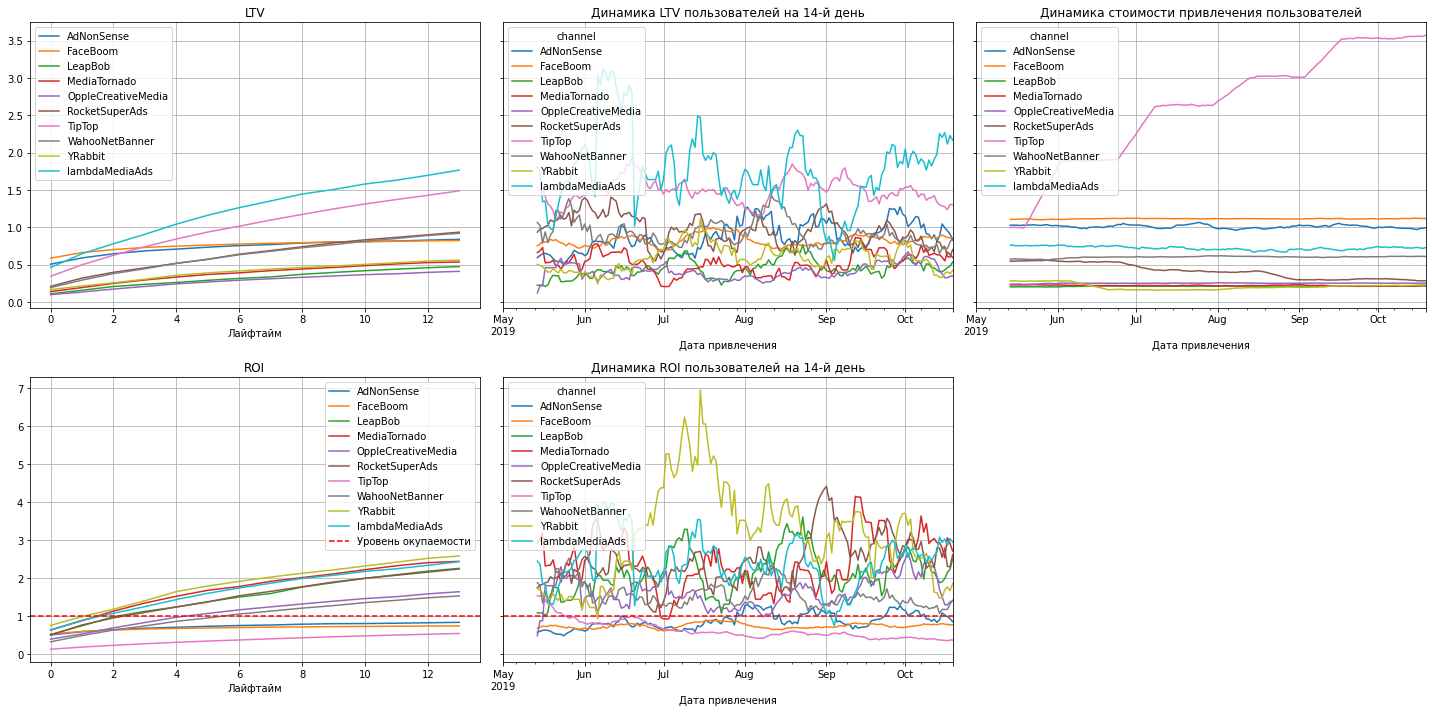

In [47]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    filtered_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

По графикам можно сделать следующие выводы:

- Большинство каналов продвижения не показывают сильный рост LVT, однако и здесь есть фавориты в лице lambdaMediaAds и TipTop
- Канал TipTop, демонстрируют значительный рост стоимости привлечения, в то время как другие каналы остаются относительно стабильными, например, AdNonSense и FaceBoom, которые показывают относительно высокую цену стоимости привлечения или другие каналы с более низкой ценой.
- Почти все каналы имеют ROI выше уровня окупаемости, что указывает на положительный возврат на инвестиции. Однако есть и те, кто не достиг этого уровня, например, TipTop, FaceBoom, AdNonSence. Возможно это связанно с высокой ценой привлечения

Стоимость привлечения клиентов для некоторых каналов значительно растет, особенно для TipTop, AdNonSense и FaceBoom, что может быть связано с увеличением расходов на маркетинг и что безусловно влияет на окупаемость этих каналов - она не достигнута.

### Напишите выводы

В целом, реклама не окупается. Несмотря на рост LTV, который указывает на увеличение доходов от клиентов по мере их взаимодействия с приложением, окупаемость рекламных кампаний не достигается. Особенно это касается рекламных каналов TipTop, FaceBoom и AdNonSense, которые, несмотря на высокий LTV, не обеспечивают достаточный возврат на инвестиции. Взглянем на факторы, которые могут негавтино повлиять на окупаемость:

- Устройства: Реклама, направленная на пользователей устройств от Apple (iPhone и Mac), оказывает негативное влияние на окупаемость. Несмотря на высокий LTV и относительно других устройств высокую конверсию, стоимость привлечения этих пользователей значительно растет, что приводит к снижению ROI.
- Страны: В США, несмотря на высокий и растущий LTV, а также высокую относительно других устройств конверсию, стоимость привлечения пользователей значительно увеличивается, что снижает общий ROI. В других странах (Франция, Германия, Великобритания) стоимость привлечения остается стабильной, и ROI находится выше уровня окупаемости.
- Каналы: Каналы TipTop, FaceBoom и AdNonSense демонстрируют значительный рост стоимости привлечения пользователей, что негативно влияет на их окупаемость. Основная часть рекламного бюджета сосредоточена на этих каналах, что также снижает общую эффективность рекламных кампаний. Стоит упомянуть, что AdNonSense и FaceBoon демонстрируют наиболее высокую конверсию. Однако эти же каналы демонстрируют более низкое удержание по сравнению с другими каналами. 

Исходя из всего вышесказанного, можно предположить, что проблему с окупаемостью главным образом вызывает значительный рост стоимости привлечения пользователей (CAC), который наблюдается с середины мая по конец периода в США, что приводит к снижению окупаемости. Также стоит отметить, что показатели удержания как платящих, так и неплатящих пользователей показывают тенденцию к снижению, в особенности США для устройств Mac и iPhone, где  удержание падает значительно быстрее. У неплатящих пользователей удержание снижается до нуля. Вдобавок более 80% рекламного бюджета сосредоточено на двух каналах (TipTop и FaceBoom), которые не достигают уровня окупаемости, несмотря на высокие показатели LTV.

На основе проведенного анализа можно дать следующие рекомендации для рекламного отдела: 

- Пересмотреть распределение рекламного бюджета, сократив долю вложений в каналы TipTop и FaceBoom и увеличив инвестиции в каналы с более стабильными и высокими показателями ROI.
- Более глубоко изучить причины и попробовать оптимизировать стоимость привлечения пользователей в США. Увеличить маркетинговые усилия в странах с более стабильными показателями окупаемости (Франция, Германия, Великобритания).
- Поработать с удержанием пользователей, как платящих, так и неплатящих, разработав меры по улучшению пользовательского опыта и повышения вовлеченности.

Для достижения окупаемости рекламных кампаний необходимо сосредоточиться на оптимизации стоимости привлечения пользователей, улучшении удержания клиентов и эффективном распределении рекламного бюджета. Особое внимание следует уделить устройствам от Apple, каналам FaceBoom и TipTop и стоимости привлечения пользователей в США, которые в текущей ситуации оказывают негативное влияние на окупаемость. Также стоит проводить регулярный анализ эффективности всех рекламных каналов, использовав данные о ROI и LTV для принятия решений о перераспределении бюджета.